This notebook runs the code from this kaggle kernel [wingbeats-basic-py](https://www.kaggle.com/potamitis/wingbeats-basic-py), which is governed by Apache 2.0 license, copyright of Ilyas Potamitis.

The data comes from this kaggle dataset [Wingbeats](https://www.kaggle.com/potamitis/wingbeats/data).

The data collection process is described in the following paper:

[http://ieeexplore.ieee.org/abstract/document/7482663/](http://ieeexplore.ieee.org/abstract/document/7482663/)

In [1]:
# First we will import many packages that we will need

from __future__ import division
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

import os
from scipy import signal

import seaborn as sn

In [2]:
# ignore some deprecation warnings
import warnings
warnings.filterwarnings('ignore')

---
### Reading the data

In [3]:
# reading the stored data
X = np.load('data/X.npy')
y = np.load('data/y.npy')

In [4]:
target_names = ['Ae. aegypti', 'Ae. albopictus', 'An. gambiae', 'An. arabiensis', 'C. pipiens', 'C. quinquefasciatus']

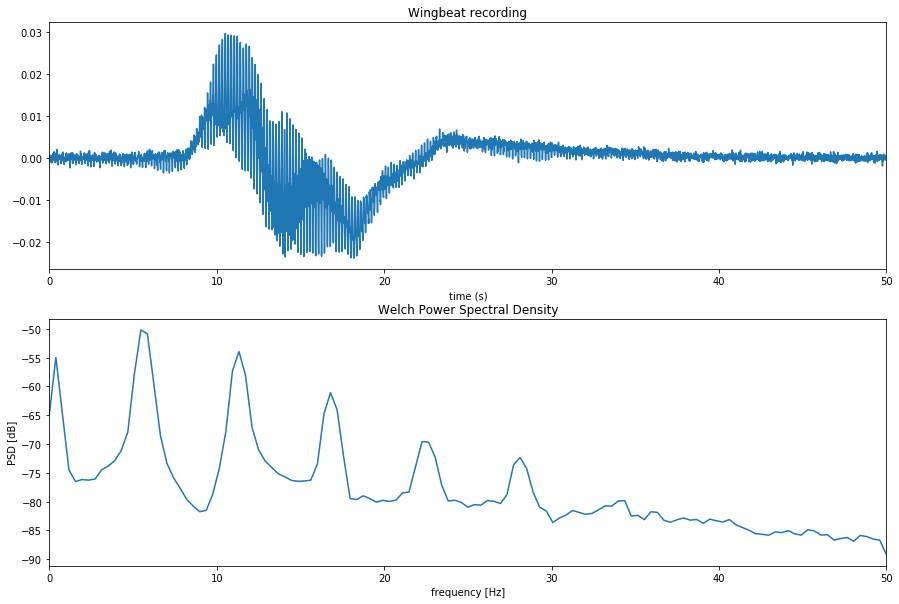

In [5]:
# transform the data
fs = 100 # frequency
XX = np.zeros((X.shape[0],129)).astype("float32")   # allocate space
for i in range(X.shape[0]):
    XX[i] = 10*np.log10(signal.welch(X[i], fs=fs, window='hanning', nperseg=256, noverlap=128+64)[1])

# Show one recording
plt.figure(figsize = (15,10))
plt.subplot(2, 1, 1)
plt.plot(np.linspace(0,X.shape[1]/fs,X.shape[1]),X[0])
plt.autoscale(enable=True, axis='x', tight=True)
plt.xlabel('time (s)')
plt.title('Wingbeat recording')

plt.subplot(2, 1, 2)
plt.plot(np.linspace(0,fs/2,129),XX[0])
plt.autoscale(enable=True, axis='x', tight=True)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [dB]')
plt.title('Welch Power Spectral Density')
plt.show()

In order to later evaluate the performance of the classifiers we split the dataset into a training and testing part, where the testing part is 20% of the total dataset. We use the `train_test_split` function for that.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(XX, y, test_size=0.20, random_state=2018)

---
### Linear Classifiers

We will first use a [Support Vector Classifier](http://scikit-learn.org/stable/modules/svm.html#mathematical-formulation) with a linear kernel.

In [7]:
%%time
# A quick result
model = SVC(kernel = 'linear', C=0.01, cache_size=200)
model.fit(X_train, y_train)

CPU times: user 2.39 s, sys: 13.7 ms, total: 2.4 s
Wall time: 2.49 s


In [8]:
# make predictions for test data
y_pred = model.predict(X_test)
ac = accuracy_score(y_test, y_pred)
print("Name: %s, ac: %f" % ('SVC', ac))

Name: SVC, ac: 0.695275


***Exercise:*** 
* Try the support vector classifier with an rbf kernel, gamma kernel. How does this affect the performance?
* Modify the regularization parameter C. What do you observe?

---
### Nonlinear Classifiers

In [9]:
%%time
# A quick result
X_train, X_test, y_train, y_test = train_test_split(XX, y, test_size=0.20, random_state=2018)
# fit model on training data
model = GradientBoostingClassifier()
model.fit(X_train, y_train)

CPU times: user 34.3 s, sys: 120 ms, total: 34.4 s
Wall time: 36.1 s


In [10]:
# make predictions for test data
y_pred = model.predict(X_test)
ac = accuracy_score(y_test, y_pred)
print("Name: %s, ac: %f" % ('Gradient Boosting', ac))

Name: Gradient Boosting, ac: 0.748312


***Exercise:***
* try a [ExtraTreesClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html), [Random Forest classifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

(default kernel classifier with rbf fails miserably)

### Evaluation performance

The *empirical accuracy* of the classifier is defined as 
$\sum_{i=1}^N \mathbb{1}\{g(X_i)==Y_i\}/N$, i.e. we are counting for how many observations we predicted the correct label. The accuracy is an overall measure and it does not tell us where the error happens. It is often useful to look at the `confusion matrix` which contains different types of errors for each category. The rows correspond to the true labels, the columns correspond to the predicted labels.

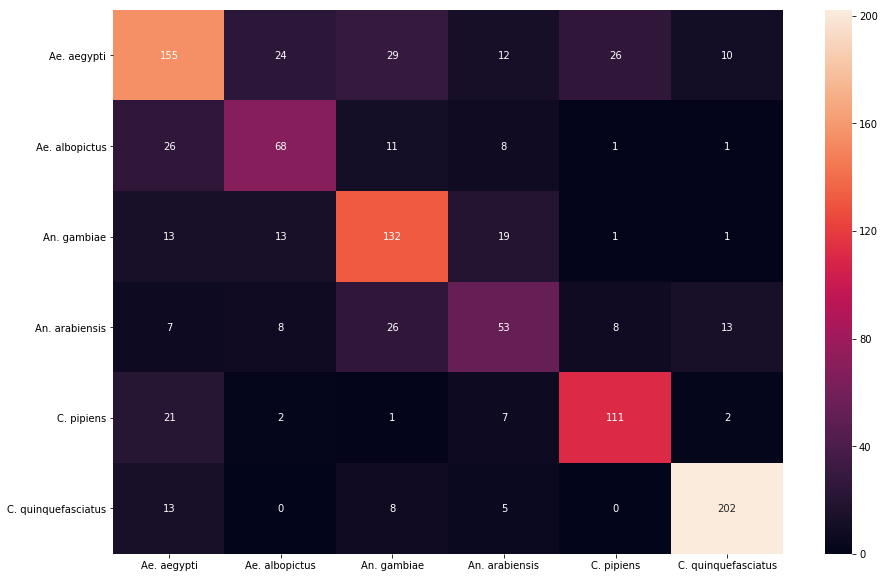

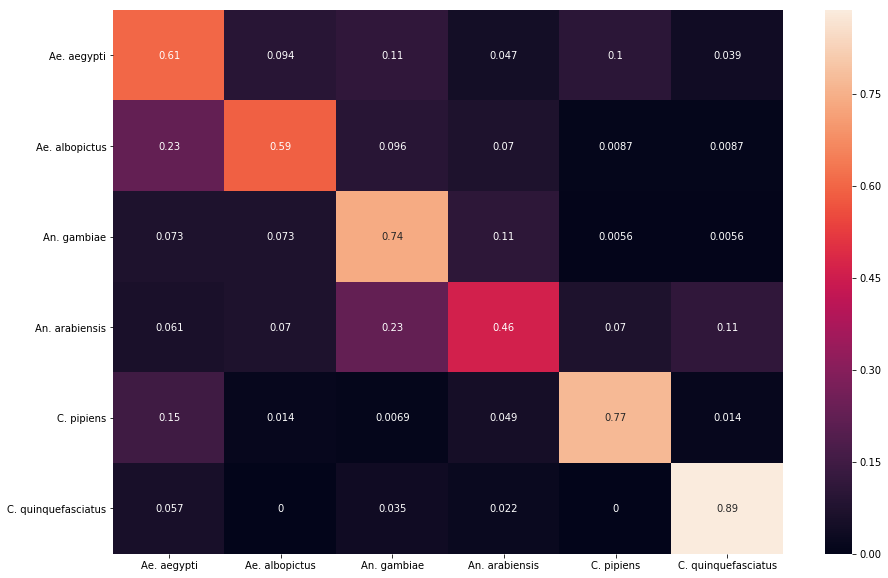

In [10]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, columns=target_names, index=target_names)
plt.figure(figsize = (15,10))
sn.heatmap(df_cm, annot=True, fmt="d")


cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm, columns=target_names, index=target_names)
plt.figure(figsize = (15,10))
sn.heatmap(df_cm, annot=True)
plt.show()

Note, in general we observe samples from the joint distribution $(X,Y)$. The *expected error* of a classifier $g$ is $P(g(X) \ne Y)$.

We would like to minimize the *generalization error*:

      generalization error = expected error - empirical error 


### Cross-validation
Above we split our dataset in two parts - train and test. To alleviate the effect of evaluating the performance only on a single dataset, we perform cross-validation by subsetting the dataset in several different train-test combinations and then average the performance over the set of testing datasets we have created. We obtain also information about the variance of the error, which might be more important than the actual mean value (and can guide us to a more robust classifier - performing similarly on different subsets).




In [11]:
# model contains the result of the gradient boosting classifier
acc_folds = cross_val_score(model, XX, y, cv=5)
print("Mean: %f, Std: %f" % (np.mean(acc_folds), np.std(acc_folds)))

KeyboardInterrupt: 

In [13]:
# list of classifiers we want to explore
names = ["Gradient Boosting", "Random Forest", "ExtraTreesClassifier", "Linear SVM", "RBF SVM"]

classifiers = [
	GradientBoostingClassifier(n_estimators=650, learning_rate=0.2),
    RandomForestClassifier(n_estimators = 650, min_samples_split = 3, min_samples_leaf = 2, random_state = 2018, n_jobs=-1),
    ExtraTreesClassifier(n_estimators = 650, random_state = 2018, n_jobs=-1),
    SVC(kernel="linear", C=0.01),
    SVC(gamma=0.008, C=.1),]

In [14]:
%%time
# CV experiments - it will take long..
# Species level
for name, clf in zip(names, classifiers):
	print(name)
	clf_ = make_pipeline(StandardScaler(), clf)
	acc_folds = cross_val_score(clf_, XX, y, cv=5)
	print("Mean: %f, Std: %f" % (np.mean(acc_folds), np.std(acc_folds)))
	print("")

Gradient Boosting


KeyboardInterrupt: 

The performance of the Gradient Boosting classifier is best. This is a generally quite robust nonlinear classifier and often outperforms Random Forests. The disadvantage is that it is more computationally expensive and harder to parallelize.

A few remarks:
* the cross validation error is a slightly biased  
* when doing parameter selection we can be prone to over-fitting even with cross-validation
* when doing dimensionality reduction we should make sure we do it only on the training set withing the fold

---
### Unabalanced Datasets

Let's consider the binary classification problem. We will pick 'Ae. albopictus' as the 1-class, and all other ones will be zero.

In [12]:
# need to convert y to binary
y_binary = (y==1)

In [13]:
# only about 11 percent of samples are True
sum(y_binary)/len(y_binary)

0.1156147461879946

In [14]:
%%time
# A quick result
X_train, X_test, y_train, y_test = train_test_split(XX, y_binary, test_size=0.20, random_state=2018)
# fit model no training data
model = GradientBoostingClassifier()
model.fit(X_train, y_train)

CPU times: user 6.13 s, sys: 11.6 ms, total: 6.15 s
Wall time: 6.39 s


In [15]:
# make predictions for test data
y_pred = model.predict(X_test)
ac = accuracy_score(y_test, y_pred)
print("Name: %s, ac: %f" % ('Gradient Boosting', ac))

Name: Gradient Boosting, ac: 0.923819


How good is that?

Let's compare to the constant predictor which always predicts zero.

In [16]:
# create a predictor which always predicts zero
y_pred0 = np.zeros(len(y_pred))
ac = accuracy_score(y_test, y_pred0)
print("Name: %s, ac: %f" % ('Zero Predictor', ac))

Name: Zero Predictor, ac: 0.889103


That is not bad either, but we will miss identifying any mosquitos of that class.

#### Receiver Operator Characteristic (ROC) & Precision-Recall (PR) Curves

In [17]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc

In [18]:
y_scores = model.decision_function(X_test)

In [19]:
# calculate the precision recall curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores, pos_label=1)

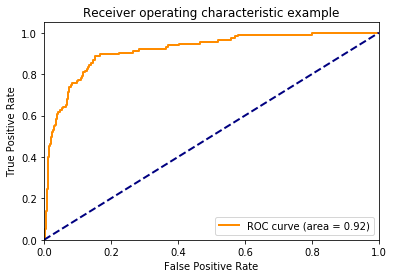

In [20]:
# plot the roc curve
plt.figure()
roc_auc = auc(fpr, tpr)
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [21]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_scores)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.61


In [22]:
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

Text(0.5,1,'2-class Precision-Recall curve: AP=0.61')

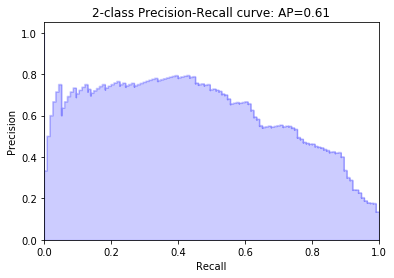

In [23]:
# plot the precision recall curve
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

A few remarks:
* We can see the ROC curve is increasing
* The P-R curve is much more irregular
* There is though a 1-1 correspondence between the curves
* When working with unbalanced dataset you should consider a stratified cross-validation
* You can balance the dataset the performance 

*** Exercise:*** 
calculate the roc/precision-recall curves for several classifiers, and decide which one is better
